# Modeling

### Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay

### Load Data
- train test split
- create target column for train and test: num_comments > median of num_comments (from training set)
- establish baseline

In [2]:
# load data
posts = pd.read_csv('data/posts_modelready.csv')

In [3]:
# establish X and y
X = posts.drop(columns='num_comments')
y = posts['num_comments']

In [4]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,  random_state=11)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14782, 25), (3696, 25), (14782,), (3696,))

In [6]:
# reset indices for compatibility with future vectorization and concatenation
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [7]:
# find median num_comments in training set
med_comments = y_train.median()

In [8]:
med_comments

22.0

In [9]:
# create actual target columns for train and test sets
abv_med_comms_train = [int(num_comms > med_comments) for num_comms in y_train]
abv_med_comms_test = [int(num_comms > med_comments) for num_comms in y_test]

In [10]:
# baseline score specific to this data
sum(abv_med_comms_test) / len(abv_med_comms_test)

0.4926948051948052

By construction, the baseline prediction method could be either to always predict a post will have less than the median number of comments or to always predict a post will have greater than the median number of comments. Either way, the baseline score should be just less than 0.5, since a post could have exactly the median number of comments, given that the median from the training set is a whole number. For this particular train and test data, the baseline score is 0.493.

### Vectorize Data

#### CountVectorize, StandardScale

In [11]:
# instantiate, fit, and transform
cvec = CountVectorizer(max_features=10_000, stop_words='english')
title_cvec_train = cvec.fit_transform(X_train['title'])
title_cvec_test = cvec.transform(X_test['title'])

In [12]:
# create cvec'ed df's for train and text, concat to originals w/o 'title'
title_cvec_train_df = pd.DataFrame(title_cvec_train.todense(), columns=cvec.get_feature_names_out())
title_cvec_test_df = pd.DataFrame(title_cvec_test.todense(), columns=cvec.get_feature_names_out())

X_train_cvec = pd.concat([X_train.drop(columns='title'), title_cvec_train_df], axis=1)
X_test_cvec = pd.concat([X_test.drop(columns='title'), title_cvec_test_df], axis=1)

In [13]:
# instantiate, fit StandardScaler on train, transform train and test
ss = StandardScaler()
ss_train = ss.fit_transform(X_train_cvec)
ss_test = ss.transform(X_test_cvec)

In [14]:
# create df's
X_train_cvec_ss = pd.DataFrame(ss_train, columns=ss.get_feature_names_out())
X_test_cvec_ss = pd.DataFrame(ss_test, columns=ss.get_feature_names_out())

In [15]:
X_train_cvec_ss

,title_len,age,has_authtext,has_linktext,subred_baseball,subred_bicycling,subred_boxing,subred_cfb,subred_climbing,subred_collegebasketball,...,črni,łks,łódź,śląsk,𝐅𝐁,𝐍𝐂𝐀𝐀,𝐏𝐥𝐚𝐲𝐢𝐧𝐠,𝐑𝐮𝐥𝐞𝐬,𝐔𝐩𝐝𝐚𝐭𝐞,𝟐𝟎𝟐𝟐
0,-0.375588,-0.731827,1.133913,-1.020505,-0.233938,-0.235542,-0.230541,4.245522,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
1,2.282394,-0.277249,1.133913,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
2,-0.393793,-0.642729,1.133913,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
3,0.134162,-0.392396,-0.881902,0.979907,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
4,0.298010,0.097290,-0.881902,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14777,-0.594052,-0.745312,-0.881902,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
14778,0.115957,-0.532691,1.133913,0.979907,4.274633,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
14779,-0.430204,0.295097,-0.881902,0.979907,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
14780,2.100340,-0.632778,1.133913,-1.020505,4.274633,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633


In [16]:
X_test_cvec_ss

,title_len,age,has_authtext,has_linktext,subred_baseball,subred_bicycling,subred_boxing,subred_cfb,subred_climbing,subred_collegebasketball,...,črni,łks,łódź,śląsk,𝐅𝐁,𝐍𝐂𝐀𝐀,𝐏𝐥𝐚𝐲𝐢𝐧𝐠,𝐑𝐮𝐥𝐞𝐬,𝐔𝐩𝐝𝐚𝐭𝐞,𝟐𝟎𝟐𝟐
0,-0.976365,-0.462934,-0.881902,-1.020505,-0.233938,4.245522,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
1,-0.211740,-0.564373,1.133913,0.979907,-0.233938,-0.235542,-0.230541,4.245522,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
2,-0.885338,0.614689,-0.881902,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
3,-1.012775,0.585229,-0.881902,0.979907,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
4,-0.594052,0.384390,-0.881902,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,-0.521231,-0.789483,-0.881902,-1.020505,-0.233938,-0.235542,4.337628,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
3692,-0.776106,-0.723700,-0.881902,0.979907,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
3693,-0.138918,0.661894,-0.881902,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633
3694,-0.557642,-0.569920,1.133913,-1.020505,-0.233938,-0.235542,-0.230541,-0.235542,-0.216527,-0.218063,...,-0.011633,-0.014247,-0.016452,-0.020151,-0.011633,-0.011633,-0.011633,-0.011633,-0.014247,-0.011633


### Model

#### Logistic Regression

- Gridsearch
    - LogisticRegression(hyperparams: C)
- Report Best Model
- Score Best Model on Test Set
- Interpret Coefficients

In [18]:
# instantiate pipe and parameters
log_pipe = Pipeline([
    ('logr', LogisticRegression(max_iter=10_000))
])

log_pipe_params = {
    'logr__C': [0.05, 0.1, 0.2, 1]
}

In [19]:
# instantiate and fit gridsearch
gscv = GridSearchCV(log_pipe, param_grid=log_pipe_params, verbose=1)

gscv.fit(X_train_cvec_ss, abv_med_comms_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('logr',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logr__C': [0.05, 0.1, 0.2, 1]}, verbose=1)

In [20]:
# best estimator
gscv.best_estimator_

Pipeline(steps=[('logr', LogisticRegression(C=0.05, max_iter=10000))])

In [21]:
# best internal score (accuracy)
gscv.best_score_

0.633608469250049

In [22]:
# score on test set (accuracy)
gscv.score(X_test_cvec_ss, abv_med_comms_test)

0.635551948051948

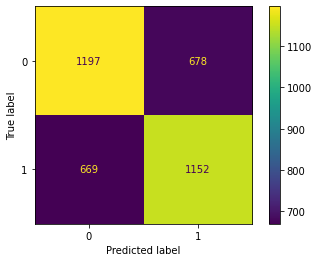

In [23]:
log_preds = gscv.predict(X_test_cvec_ss)
ConfusionMatrixDisplay.from_predictions(abv_med_comms_test, log_preds);

Model Metrics Summary:
- Accuracy: 0.636
- Precision: 0.630
- Recall: 0.633
- Specificity: 0.638

All four metrics are remarkably close together, indicating that the model is relatively balanced in the way it makes predictions. Accuracy is about 0.15 better than baseline accuracy. Considering the variation in the nature of various sports and behavior in the corresponding subreddits--EDA of popular words by subreddit indicated divergence between competition- and player-related words for sports related to games played primarily by professionals and community-related words for games and hobbies in which individuals engage personally--this improvement upon the baseline is not bad. Accuracy is the most important metric here, since we care primarily about making accurate predictions and there are not significant downsides to specific error types.

In [24]:
pd.DataFrame(gscv.best_estimator_.named_steps['logr'].coef_.reshape(-1), index=X_train_cvec_ss.columns, columns=['coefficient']).sort_values(by='coefficient', ascending=False)[:25]

,coefficient
subred_nfl,0.526854
subred_nascar,0.398708
consecutive,0.373027
discussion,0.355304
700,0.352740
competing,0.335632
thread,0.334932
subred_nba,0.298772
cottonwood,0.293808
kansas,0.291334


Coefficient Interpretation:
- Certain sports generate more comments (nfl, nascar, nba, boxing, cfb)
- People like discussing (discussion, thread, ask)
- People like certain teams (kansas, manchester, arsenal, juventus)


In [25]:
pd.DataFrame(gscv.best_estimator_.named_steps['logr'].coef_.reshape(-1), index=X_train_cvec_ss.columns, columns=['coefficient']).sort_values(by='coefficient')[:25]

,coefficient
subred_fishing,-0.634062
subred_bicycling,-0.470412
subred_golf,-0.384486
st,-0.360505
subred_tennis,-0.354848
nil,-0.317786
general,-0.308640
subred_soccer,-0.295550
shimano,-0.277896
postgame,-0.276120


Coefficient Interpretation:
- Certain sports generate less discussion (fishing, bicycling, golf, tennis, soccer)
- People dislike discussing scoreless games (nil)
- Words unrelated to sport itself generate little discussion (betting, source,stripped, etc.)

#### Random Forest Classification
- Gridsearch
    - RandomForestClassifier(hyperparams: n_estimators, max_depth, min_impurity_decrease)
- Report Best Model
- Score Best Model on Test Set
- Examine Feature Importances

In [26]:
# instantiate pipe and parameters: basic parameters
rfc_pipe = Pipeline([
    ('rfc', RandomForestClassifier())
])

rfc_pipe_params = {
    'rfc__max_depth': [None, 20, 10, 5]
}

In [27]:
# instantiate and fit gridsearch: basic parameters
gscv_rfc = GridSearchCV(rfc_pipe, param_grid=rfc_pipe_params, verbose=1)

gscv_rfc.fit(X_train_cvec_ss, abv_med_comms_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [None, 20, 10, 5]}, verbose=1)

In [28]:
# best estimator: basic parameters
gscv_rfc.best_estimator_

Pipeline(steps=[('rfc', RandomForestClassifier())])

In [29]:
# best internal score (accuracy): basic parameters
gscv_rfc.best_score_

0.7076845246457685

In [30]:
# score on test set (accuracy): basic parameters
gscv_rfc.score(X_test_cvec_ss, abv_med_comms_test)

0.7002164502164502

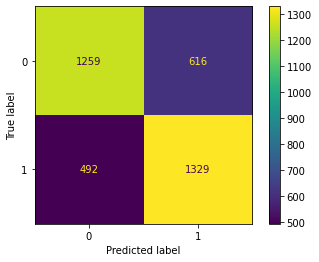

In [31]:
rfc_preds1 = gscv_rfc.predict(X_test_cvec_ss)
ConfusionMatrixDisplay.from_predictions(abv_med_comms_test, rfc_preds1);

Interpretation of this preliminary RFC model is relevant only in relation to final RFC model, below.

In [32]:
# instantiate full parameters
rfc_pipe_params_full = {
    'rfc__max_depth': [None, 20],
    'rfc__min_impurity_decrease': [0, .02, .05],
    'rfc__n_estimators': [100, 200]
}

In [33]:
# instantiate and fit gridsearch: full parameters
gscv_rfc_full = GridSearchCV(rfc_pipe, param_grid=rfc_pipe_params_full, verbose=1)

gscv_rfc_full.fit(X_train_cvec_ss, abv_med_comms_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [None, 20],
                         'rfc__min_impurity_decrease': [0, 0.02, 0.05],
                         'rfc__n_estimators': [100, 200]},
             verbose=1)

In [34]:
# best estimator: full parameters
gscv_rfc_full.best_estimator_

Pipeline(steps=[('rfc',
                 RandomForestClassifier(min_impurity_decrease=0,
                                        n_estimators=200))])

In [35]:
# best internal score: full parameters
gscv_rfc_full.best_score_

0.709239972304886

In [36]:
# score on test set (accuracy): full parameters
gscv_rfc_full.score(X_test_cvec_ss, abv_med_comms_test)

0.7026515151515151

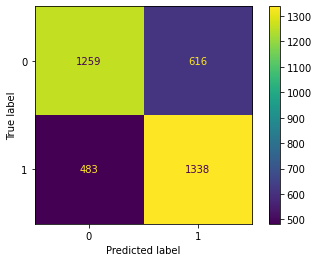

In [37]:
rfc_full_preds1 = gscv_rfc_full.predict(X_test_cvec_ss)
ConfusionMatrixDisplay.from_predictions(abv_med_comms_test, rfc_full_preds1);

Model Metrics Summary:
- Accuracy: 0.703
- Precision: 0.685
- Recall: 0.735
- Specificity: 0.671

The random forest classifier outperforms the logistic regression. Using more estimators is preferred but barely improves performance. That limits on tree depth and impurity decrease do not improve the model suggests that the model is not prone to overfitting and might suffer from bias. The general similarity of the four metrics again indicates that the model is making predictions in a fairly balanced way, though in this model the recall score is a bit higher, while precision and specificity are lower. This indicates that the model might be predicting above-median engagement too often. Still, even if there were in some application a significant cost to a certain type of error, this model would perform reasonably well.

In [38]:
pd.DataFrame(gscv_rfc_full.best_estimator_.named_steps['rfc'].feature_importances_, index=X_train_cvec_ss.columns, columns=['feature importances']).sort_values(by='feature importances', ascending=False)[:25]

,feature importances
title_len,0.042312
age,0.041821
has_authtext,0.018456
subred_fishing,0.013329
subred_bicycling,0.010905
subred_nfl,0.008439
subred_golf,0.007137
subred_nascar,0.006979
has_linktext,0.005806
subred_nba,0.005459


Feature Importance Interpretation (using signs of coefficients from logistic regression):
- Subreddit makes a big difference in engagement:
    - Higher engagement:
        - nfl
        - nascar
        - nba
        - boxing
        - cfb
    - Lower engagement:
        - fishing
        - bicycling
        - golf
        - tennis
- Title descriptiveness increases engagement (title_len, age, has_authtext, has_linktext)
- Titles designed to encourage engagement do so (thread, discussion)
- Titles related to current teams generate engagement (team, 2022)

In [47]:
# used to fetch coefficient signs from logistic regression for better interpretation of important features from random forest classifier
pd.DataFrame(gscv.best_estimator_.named_steps['logr'].coef_.reshape(-1), index=X_train_cvec_ss.columns, columns=['coefficient']).loc['has_linktext']

coefficient    0.12921
Name: has_linktext, dtype: float64